# Energy normalization 

To apply wasserstein distence to seismic signals, two things need to be considered:
- How to deal with the negative part in the signal
- How to deal with the signal has same shape but difference amplitude



In [1]:
using PyPlot
using LinearAlgebra
# using Interpolations

In [2]:
function gauss_func(t, b, c)
    y = exp.(-(t.-b).^2 ./ (2*c^2));
    return y./maximum(y)
end

function sin_func(t, omega, phi)
    return sin.(2*pi*omega*(t .- phi));
end

function ricker_func(t, t0, sigma)
    t = t.-t0;
    f = (1 .- t.^2 ./ sigma.^2) .* exp.(- t.^2 ./ (2 .* sigma.^2));
    return f
end
function wasserstein_1d(f, g; p=2)
    F = zeros(Nt); G = zeros(Nt);
    G_inv_F = zeros(Nt);
    for i = 1:Nt
        F[i] = sum(f[1:i]);
        G[i] = sum(g[1:i]);
    end
    w = sum(abs.((F-G).^p)).^(1/p)
    return w
end

wasserstein_1d (generic function with 1 method)

In [3]:
Nt = 201;
dt = 1/100;
t = range(0, length=Nt, step=dt);

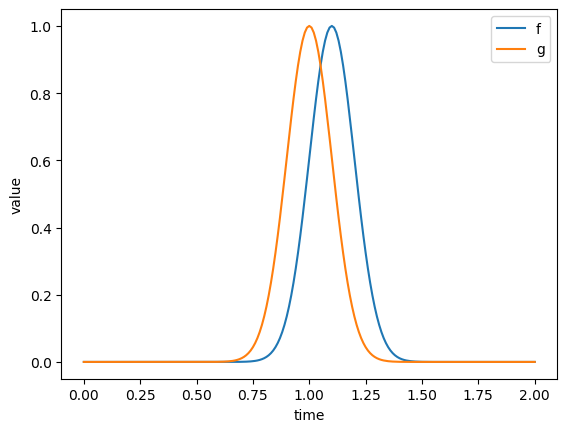

PyObject <matplotlib.legend.Legend object at 0x13a7caa90>

In [4]:
f = gauss_func(t, 1.1, 0.1);
g = gauss_func(t, 1, 0.1);
plot(t,f,t,g);
xlabel("time"); ylabel("value"); PyPlot.legend(("f", "g"))

## Mass point
Let's try the energy normalization. First, consider the oscillating mass point, recall the mechanical energy in physics,
$$E = E_p + E_k = mgh + \frac{1}{2}mv^2.$$
In this case we try to compute the mechanical energy of each point in the signal.

In [5]:
function energy_normalization(f, Nt, dt)
    g = 9.8
    m = 1
    v = zeros(Nt);
    v[2:end-1] = (f[1:end-2]-f[3:end]) ./ (2*dt);
    e = m*g*abs.(f) + 0.5*m.*v.^2;
    e = e ./ (norm(e, 1)*dt)
    return e
end

energy_normalization (generic function with 1 method)

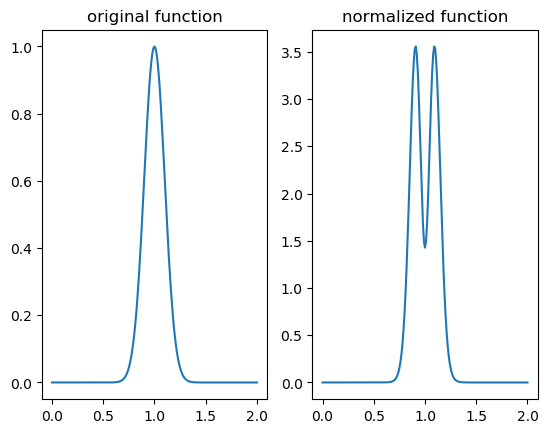

PyObject Text(0.5, 1, 'normalized function')

In [6]:
g = gauss_func(t, 1, 0.1);
subplot(121); plot(t,g); PyPlot.title("original function")
g = energy_normalization(g, Nt, dt);
subplot(122); plot(t,g); PyPlot.title("normalized function")

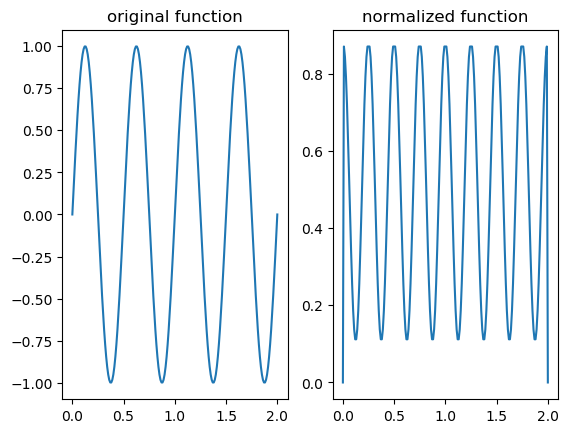

PyObject Text(0.5, 1, 'normalized function')

In [7]:
g = sin_func(t, 2, 0);
subplot(121); plot(t,g); PyPlot.title("original function")
g = energy_normalization(g, Nt, dt);
subplot(122); plot(t,g); PyPlot.title("normalized function")

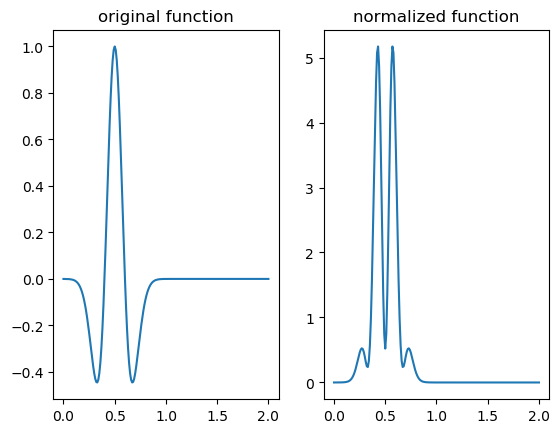

PyObject Text(0.5, 1, 'normalized function')

In [8]:
g = ricker_func(t, 0.5, 0.1);
subplot(121); plot(t,g); PyPlot.title("original function")
g = energy_normalization(g, Nt, dt);
subplot(122); plot(t,g); PyPlot.title("normalized function")

## Wave equation
Consider the energy conservation of the wave equation:
$$ u_{tt}(x,t) - \Delta u(x,t) = 0 \\ u_t(x,0) = 0$$

The energy can be defined as:
$$E(t) = \frac{1}{2} \int u^2_t(x,t) + |Du(x,t)|^2 \ dx, \ (0\leq t\leq T).$$
And we have $$\dot E(t) = 0.$$

Test with a numerical solver of 1d transport equation:

In [9]:
Nx = 201;
dx = 0.01;
x = range(0,length=Nx,step=dx);

u0 = ricker_func(x, 1, 0.05);
u1 = ricker_func(x, 1, 0.05);
U = zeros(Nx,Nt);

dt = 0.01;
Nt = 100;
t = range(0,length=Nt,step=dt);

In [10]:
for iter = 1:Nt
    u1[2:end-1] = u0[2:end-1] + dt/(2*dx).*(u0[3:end]-u0[2:end-1]);
    U[:,iter] = u1;
    u0 = u1;
end

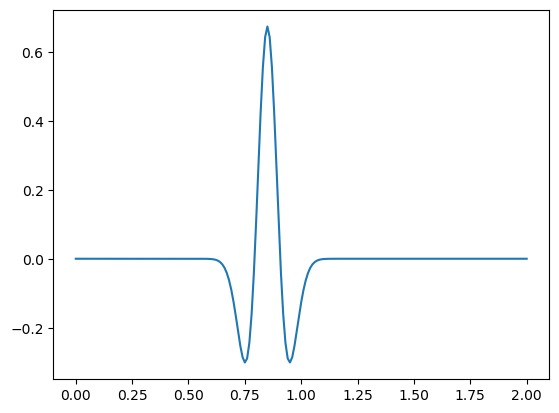

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13f30d390>

In [11]:
plot(x, U[:,30])

In [12]:
function energy_normalization_wave(U, ind, dx, dt, Nx)
    ut = zeros(Nt);
    ux = zeros(Nx);
    
    ut = (U[:,ind-1] + U[:,ind+1]) ./ (2*dt);
    ux[2:end-1] = (U[3:end,ind] - U[1:end-2,ind]) ./ (2*dx)
    
    e = 0.5 * (ut.^2 + ux.^2);
    e = e ./ (norm(e, 1))
    return e
end

energy_normalization_wave (generic function with 1 method)

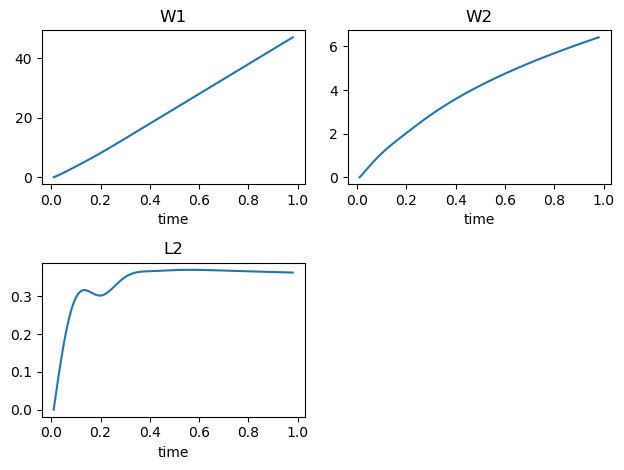

In [13]:
e2 = energy_normalization_wave(U, 2, dx, dt, Nx);
w1_misfit = zeros(Nt)
w2_misfit = zeros(Nt)
l2_misfit = zeros(Nt)
for iter = 2:99
    ee = energy_normalization_wave(U, iter, dx, dt, Nx);
    w1_misfit[iter] = wasserstein_1d(e2, ee; p=1)
    w2_misfit[iter] = wasserstein_1d(e2, ee; p=2)
    l2_misfit[iter] = norm(ee-e2, 2)
end
subplot(221); plot(t[2:99],w1_misfit[2:99]); xlabel("time"); title("W1")
subplot(222); plot(t[2:99],w2_misfit[2:99]); xlabel("time"); title("W2")
subplot(223); plot(t[2:99],l2_misfit[2:99]); xlabel("time"); title("L2")
PyPlot.tight_layout()

### test with 1d wave eq

In [14]:
Nx = 201;
dx = 0.01;
x = range(0,length=Nx,step=dx);

u0 = ricker_func(x, 1, 0.05);
u1 = ricker_func(x, 1, 0.05);
u2 = zeros(Nx);
U = zeros(Nx,Nt);

dt = 0.01;
Nt = 70;
t = range(0,length=Nt,step=dt);

for iter = 1:Nt
    u2[2:end-1] = 2*u1[2:end-1] - u0[2:end-1] + dt^2/dx^2 * (u1[3:end]-2*u1[2:end-1]+u1[1:end-2]) ;
    u0[:] = u1[:]
    u1[:] = u2[:]
    U[:,iter] = u2;
end

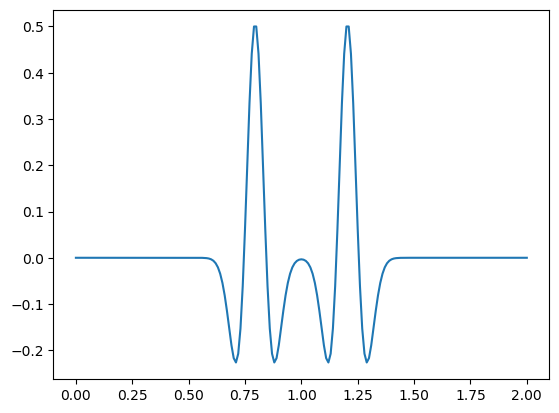

In [15]:
plot(x,U[:,20]); 

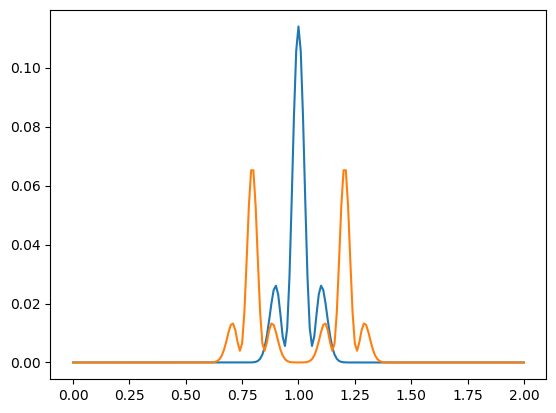

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13fd25160>
 PyObject <matplotlib.lines.Line2D object at 0x13fd252b0>

In [16]:
e2 = energy_normalization_wave(U, 2, dx, dt, Nx);
e20 = energy_normalization_wave(U, 20, dx, dt, Nx);
plot(x, e2, x, e20)

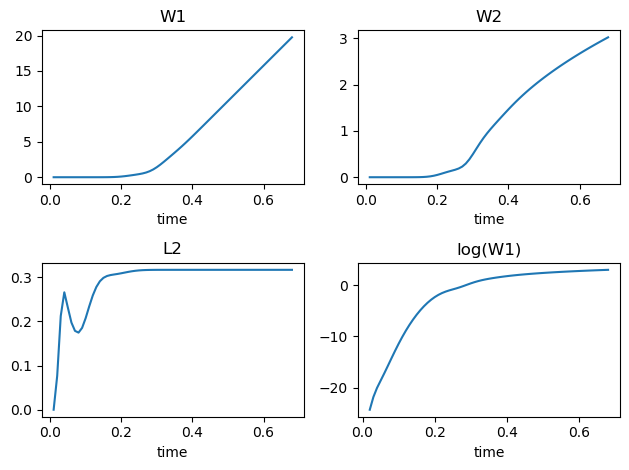

In [17]:
e2 = energy_normalization_wave(U, 2, dx, dt, Nx);
w1_misfit = zeros(Nt)
w2_misfit = zeros(Nt)
l2_misfit = zeros(Nt)
for iter = 2:69
    ee = energy_normalization_wave(U, iter, dx, dt, Nx);
    w1_misfit[iter] = wasserstein_1d(e2, ee; p=1)
    w2_misfit[iter] = wasserstein_1d(e2, ee; p=2)
    l2_misfit[iter] = norm(ee-e2, 2)
end
subplot(221); plot(t[2:69],w1_misfit[2:69]); xlabel("time"); title("W1")
subplot(222); plot(t[2:69],w2_misfit[2:69]); xlabel("time"); title("W2")
subplot(223); plot(t[2:69],l2_misfit[2:69]); xlabel("time"); title("L2")
subplot(224); plot(t[2:69],log.(w1_misfit[2:69])); xlabel("time"); title("log(W1)")
PyPlot.tight_layout()